In [46]:
import re 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
sns.set_style("whitegrid")
import matplotlib
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14

In [31]:
fleetsize_07 = []
for month in range(1, 13):
    for day in range(1, 32):
        if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
            continue  # Skip invalid date
        with open(f'../output/demand_variation/fleet_op_result/alpha_7/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
            fleetsize_07.append(int(float(re.search(r'\d+(\.\d+)?', f.readline())[0])))

fleetsize_07 = np.array(fleetsize_07)


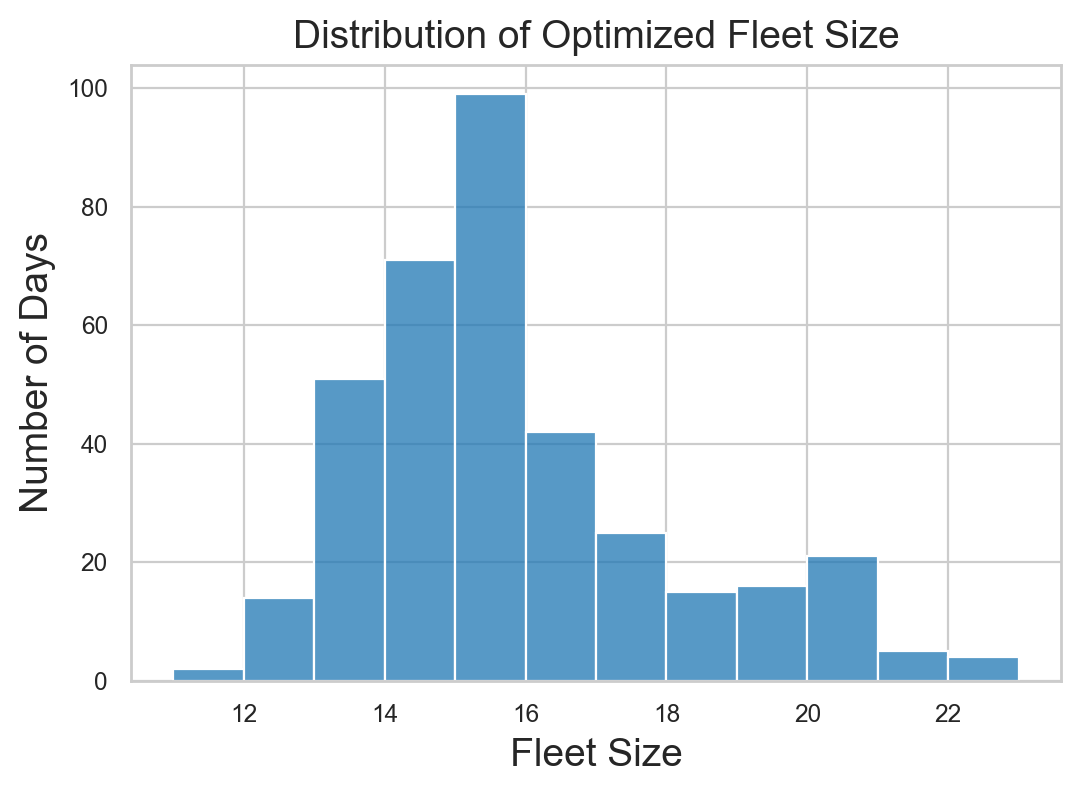

In [32]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200)
sns.histplot(fleetsize_07, binwidth=1, ax=ax)
ax.set(xlabel='Fleet Size', ylabel='Number of Days', title='Distribution of Optimized Fleet Size');

In [33]:
input_fleet_size = 12
for month in range(1, 13):
    for day in range(1, 32):
        if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
            continue  # Skip invalid date

        
        with open(f'../output/demand_variation/fleet_op_result/alpha_7/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
            fleetsize = int(float(re.search(r'\d+(\.\d+)?', f.readline())[0]))
            if fleetsize > input_fleet_size:
                pass

In [17]:
result = pd.DataFrame({'val':np.concatenate([fleetsize_06, fleetsize_07]), 'alpha':np.concatenate([np.repeat(0.6, len(fleetsize_06)), np.repeat(0.7, len(fleetsize_07))])})

Text(0.5, 1.0, 'Distribution of Fleet Size for 365 Autorregressive Samples')

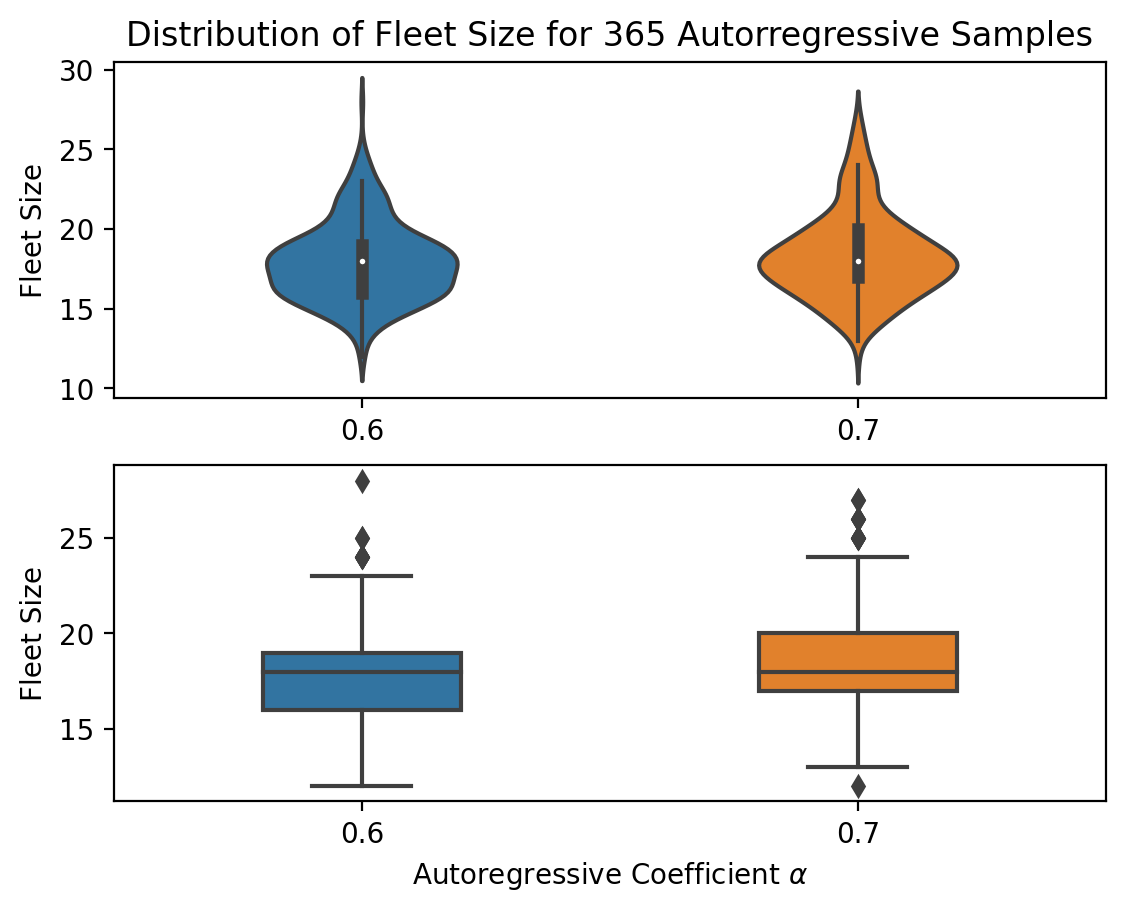

In [38]:
fig, ax = plt.subplots(nrows=2, dpi=200)
sns.violinplot(data=result, x='alpha', y='val',width=0.4, ax=ax[0])
sns.boxplot(data=result, x='alpha', y='val',width=0.4, ax=ax[1])
ax[0].set(xlabel='')
ax[1].set(xlabel='Autoregressive Coefficient $\\alpha$')
for i in range(2):
    ax[i].set(ylabel='Fleet Size')
ax[0].set_title('Distribution of Fleet Size for 365 Autorregressive Samples')


In [98]:
path = '../output/demand_variation/schedule/'

flight_demand_06 = []
flight_demand_07 = []
for month in range(1, 13):
    for day in range(1, 32):
        if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
            continue  # Skip invalid date

        flight_demand_06.append(pd.read_csv(path+f'{month}_{day}_6.csv').shape[0])
        flight_demand_07.append(pd.read_csv(path+f'{month}_{day}_7.csv').shape[0])

flight_demand_06 = np.array(flight_demand_06)
flight_demand_07 = np.array(flight_demand_07)


In [64]:
fleetsize_06

array([18, 18, 15, 16, 23, 17, 18, 18, 16, 15, 16, 19, 21, 15, 18, 23, 18,
       18, 17, 16, 17, 18, 20, 19, 21, 19, 21, 18, 22, 19, 15, 16, 17, 17,
       19, 16, 18, 17, 18, 15, 20, 17, 22, 15, 16, 16, 17, 18, 20, 16, 18,
       15, 18, 19, 16, 14, 16, 24, 15, 20, 19, 22, 16, 16, 16, 19, 19, 22,
       18, 19, 21, 15, 16, 19, 15, 17, 21, 19, 19, 12, 18, 22, 19, 18, 19,
       17, 16, 20, 16, 18, 19, 18, 19, 20, 16, 17, 19, 19, 22, 17, 14, 18,
       16, 19, 18, 15, 20, 15, 19, 14, 18, 17, 12, 18, 18, 17, 18, 18, 20,
       16, 19, 25, 17, 17, 18, 17, 13, 17, 22, 13, 13, 17, 16, 19, 20, 18,
       18, 19, 21, 21, 20, 15, 16, 16, 14, 18, 18, 18, 20, 18, 20, 21, 23,
       17, 17, 16, 16, 19, 23, 16, 17, 15, 16, 17, 16, 22, 18, 16, 22, 22,
       18, 19, 19, 21, 15, 16, 21, 19, 14, 20, 18, 19, 15, 17, 19, 16, 14,
       17, 19, 18, 15, 16, 21, 17, 16, 16, 18, 22, 15, 17, 16, 18, 24, 18,
       18, 18, 17, 17, 18, 17, 18, 15, 20, 16, 17, 20, 15, 19, 14, 15, 19,
       17, 14, 19, 19, 16

In [144]:
def num_flights_unserved(fleetsize, flight_demand, percentile, return_fleetsize=False):
    n = len(fleetsize)
    fleetsize = sorted(fleetsize)
    num_aircraft = fleetsize[int(n*percentile)]

    condition = fleetsize > num_aircraft
    unserved_demand = flight_demand[condition].sum()

    if return_fleetsize:
        return num_aircraft
    else:
        return unserved_demand/flight_demand.sum()
    

In [123]:
percentile = np.arange(0.8,0.99,0.01)

In [124]:
num_flights_unserved(fleetsize_06, flight_demand_06, 0.9)

0.10039069664429995

Text(0.855, 0.086, 'Fleetsize: 21')

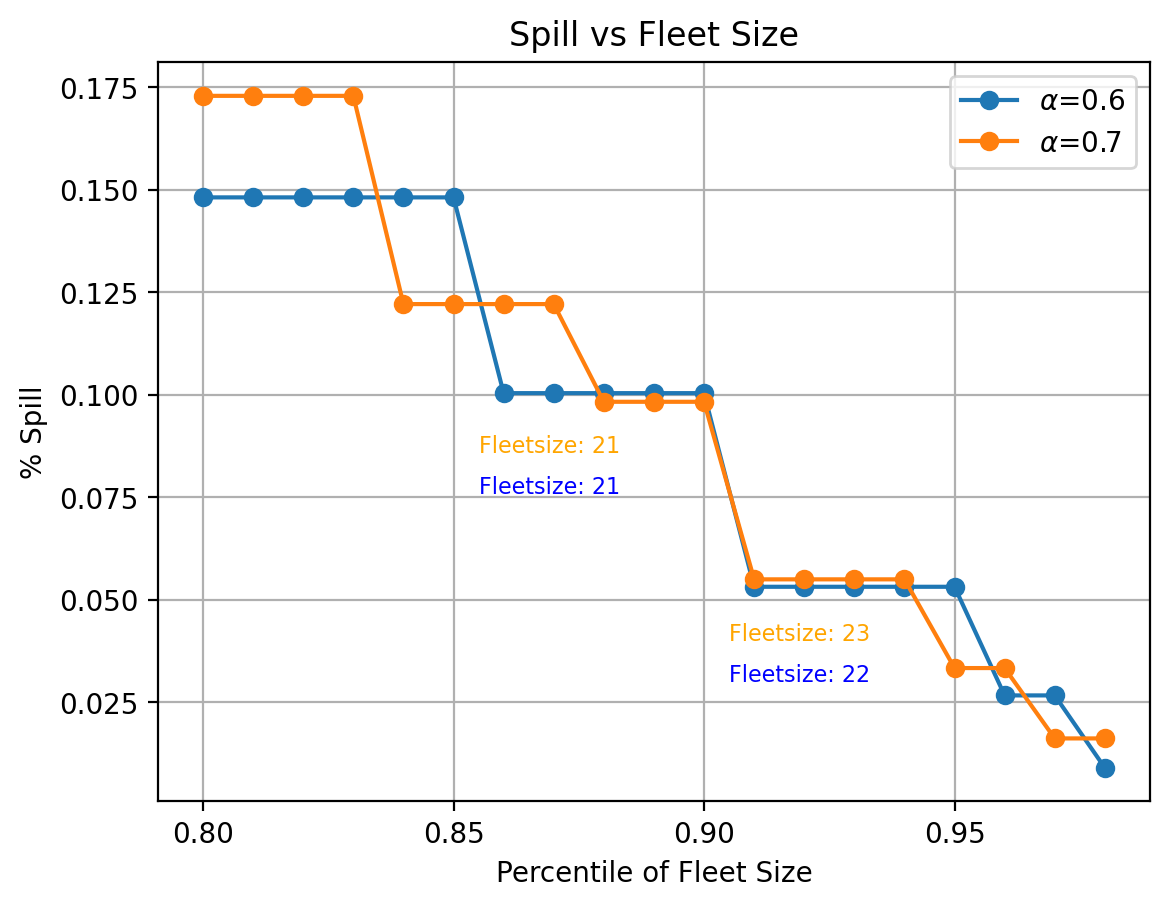

In [171]:
vf06 = np.vectorize(lambda x: num_flights_unserved(fleetsize_06, flight_demand_06, x))
vf07 = np.vectorize(lambda x: num_flights_unserved(fleetsize_07, flight_demand_07, x))
fig, ax = plt.subplots(dpi=200)
ax.plot(percentile, vf06(percentile), label='$\\alpha$=0.6', marker='o')
ax.plot(percentile, vf07(percentile), label='$\\alpha$=0.7', marker='o')
ax.set(xlabel='Percentile of Fleet Size', ylabel='% Spill',
       xticks=np.arange(0.8, 1, 0.05),
       title='Spill vs Fleet Size')
plt.legend()
plt.grid()

ax.text(0.905,
        0.03,
        f'Fleetsize: {num_flights_unserved(fleetsize_06, flight_demand_06, 0.91, return_fleetsize=True)}',
        color='blue',
        size=8)

ax.text(0.905,
        0.04,
        f'Fleetsize: {num_flights_unserved(fleetsize_07, flight_demand_07, 0.91, return_fleetsize=True)}',
        color='orange',
        size=8)

ax.text(0.855,
        0.076,
        f'Fleetsize: {num_flights_unserved(fleetsize_06, flight_demand_06, 0.86, return_fleetsize=True)}',
        color='blue',
        size=8)

ax.text(0.855,
        0.086,
        f'Fleetsize: {num_flights_unserved(fleetsize_07, flight_demand_07, 0.86, return_fleetsize=True)}',
        color='orange',
        size=8)



In [51]:

path = '../output/demand_variation/schedule/'
all_files = os.listdir(path)
all_files = sorted([file for file in all_files if file.endswith("6")])
for i in all_files:
    os.rename(path+i, path+i+'.csv')

In [48]:
import os

directory_path = "../output/demand_variation/schedule"  # Replace with the path to your directory

# List all files in the directory
file_list = os.listdir(directory_path)

# Iterate through the files and delete those ending with "7"
for filename in file_list:
    if filename.endswith(".txt"):
        file_path = os.path.join(directory_path, filename)
        os.remove(file_path)
        print(f"Deleted: {filename}")


Deleted: 5_5_6.txt
Deleted: 6_4_6.txt
Deleted: 2_25_6.txt
Deleted: 3_25_6.txt
Deleted: 10_8_6.txt
Deleted: 1_17_6.txt
Deleted: 3_8_6.txt
Deleted: 2_18_6.txt
Deleted: 3_18_6.txt
Deleted: 8_27_6.txt
Deleted: 9_27_6.txt
Deleted: 4_1_6.txt
Deleted: 7_12_6.txt
Deleted: 6_12_6.txt
Deleted: 5_20_6.txt
Deleted: 4_20_6.txt
Deleted: 5_22_6.txt
Deleted: 4_22_6.txt
Deleted: 7_10_6.txt
Deleted: 6_10_6.txt
Deleted: 9_9_6.txt
Deleted: 8_18_6.txt
Deleted: 9_18_6.txt
Deleted: 1_31_6.txt
Deleted: 4_3_6.txt
Deleted: 8_25_6.txt
Deleted: 9_25_6.txt
Deleted: 7_2_6.txt
Deleted: 1_28_6.txt
Deleted: 6_6_6.txt
Deleted: 5_7_6.txt
Deleted: 1_15_6.txt
Deleted: 2_27_6.txt
Deleted: 3_27_6.txt
Deleted: 8_9_6.txt
Deleted: 2_23_6.txt
Deleted: 3_23_6.txt
Deleted: 1_11_6.txt
Deleted: 5_3_6.txt
Deleted: 7_30_6.txt
Deleted: 6_30_6.txt
Deleted: 6_2_6.txt
Deleted: 7_14_6.txt
Deleted: 6_14_6.txt
Deleted: 5_26_6.txt
Deleted: 4_26_6.txt
Deleted: 7_29_6.txt
Deleted: 6_29_6.txt
Deleted: 8_21_6.txt
Deleted: 9_21_6.txt
Deleted: 7_6

In [47]:
files = os.listdir('../output/demand_variation/spill_op_result/alpha_7')
all_files = []
for file in files:
    if file.endswith('_total_spill.txt'):
        all_files.append(file)
file_names = np.empty(shape=(0, 3))
for i in all_files:
    file_names = np.vstack((file_names, np.array(i.split('_')[:3])))

In [62]:
os.chdir('../')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
import model.queueing_model
importlib.reload(model.queueing_model)
from model.queueing_model import system
from tqdm import tqdm

In [64]:
os.getcwd()

'/Users/Albert/Desktop/Supernal/UAM_system_optimization'

In [ ]:
y_nt = np.zeros(4)
for month in tqdm(range(1, 13)):
    for day in range(1, 32):
        if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
            continue  # Skip invalid dates
        else:
            with open(f'output/demand_variation/fleet_op_result/alpha_7/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
                fleetsize = int(float(re.search(r'\d+(\.\d+)?', f.readline())[0]))
            
            for i in range(12, 16):
                if fleetsize > i:
                    s = system(i, f'output/demand_variation/schedule/alpha_7/num_pax_{month}_{day}.csv', f'output/demand_variation/schedule/alpha_7/{month}_{day}.csv')
                    y_nt[i-12] += s.logger(True)
    

In [87]:
y_nt / 365

array([721.36986301, 599.2739726 , 450.52328767, 272.44657534])

In [79]:
x = np.arange(10)+15
y = np.zeros(10, dtype=int)

In [81]:
for i in range(file_names.shape[0]):
    with open('output/demand_variation/spill_op_result/alpha_7/'+all_files[1], 'r') as f:
        spill = float(f.readline().split(': ')[1])
    y[int(file_names[i,2])-15] += spill


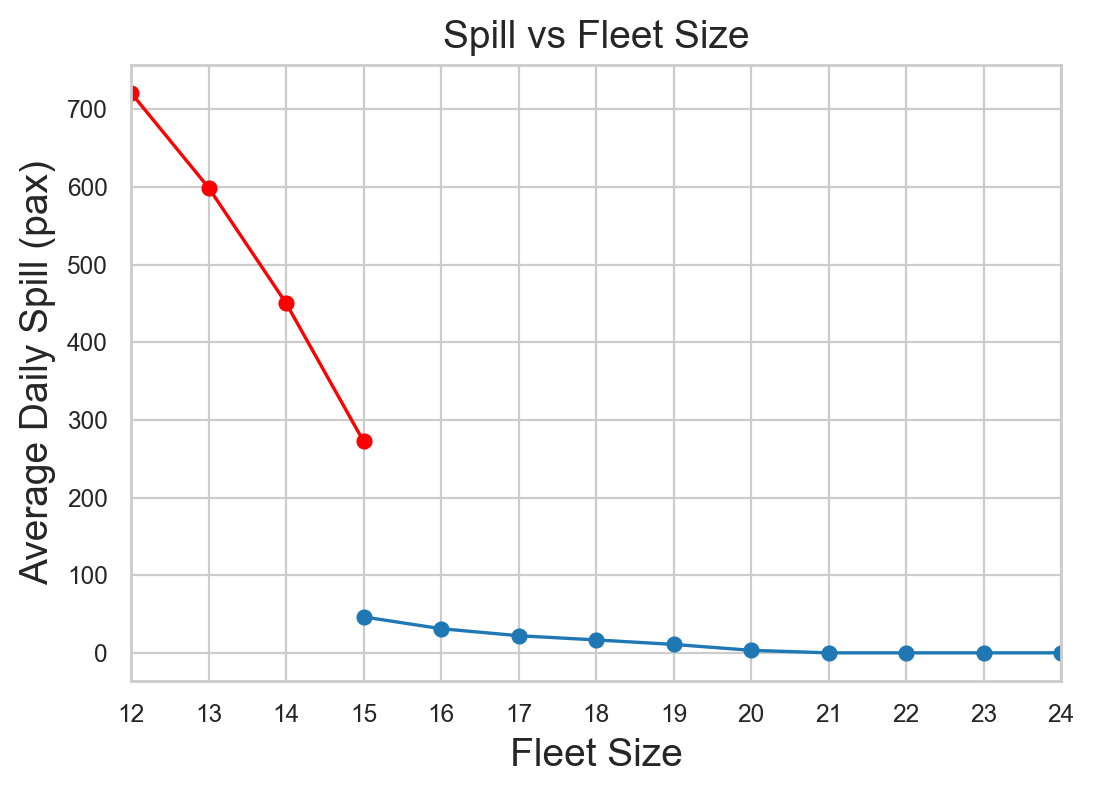

In [89]:
fig, ax = plt.subplots(dpi=200, figsize=(6,4))
ax.plot(x, y/365, marker='o')
ax.plot(np.arange(12, 16), y_nt/365, marker='o', color='red')
ax.set(xlabel='Fleet Size', ylabel='Average Daily Spill (pax)', title='Spill vs Fleet Size',
       xticks=np.arange(12, 25, 1),
       xlim=(12, 24));

In [ ]:
# beta * F to give a cost of acquiring a new aircraft
# full process documented
# seat capacity of a flght / seats of the entire year * (365*1500)